In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pip Install

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import

In [ ]:
import os
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import PIL
from tqdm import tqdm
import cv2
from sklearn.metrics import classification_report, roc_curve
import pandas as pd
import re
import string
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import label_binarize

# Functions

In [ ]:
def transform_fn(img):
  img = img.resize((128,128))
  tensor = transforms.ToTensor()(img)
  return tensor

def transform_fl(img):
  img = img.resize((64,64))
  tensor = transforms.ToTensor()(img)
  return tensor

def model_return(ckpt_path, model_obj):
  ckpt = torch.load(ckpt_path)
  model_obj.load_state_dict(ckpt['state_dict'])
  return model_obj.eval().cuda()

def confusion_matrix(pred,true):
  conf_matrix = np.zeros((10,10),dtype='uint8')
  for i in tqdm(range(len(pred))):
    conf_matrix[pred[i]][true[i]]+=1
  print(conf_matrix)

def accuracy(pred,true):
  class_vector = np.zeros((1,10))
  total_vector = np.zeros((1,10))
  total_correct = 0
  for i in range(len(pred)):
    if pred[i]==true[i]:
      total_correct+=1
      class_vector[0][true[i]]+=1
    total_vector[0][true[i]]+=1
  print("\nOverall Accuracy = ", 100*total_correct/len(pred), "%")
  print("\nClass-Wise Accuracies = ", 100*class_vector/total_vector)
  print(classification_report(pred,true))

def detect(test_loader, model_class):
  pred=[]
  true=[]
  proba=[]
  for i,j in tqdm(test_loader):
    i,j = i.cuda(), j.cuda()
    prob = model_class(i)
    out = prob.max(1, keepdim=True)[1]
    pred.append(out.detach().cpu().item())
    true.append(j.detach().cpu().item())
    proba.append(prob.detach().cpu().numpy())
  print("Confusion Matrix:\n")
  confusion_matrix(pred, true)
  accuracy(pred, true)
  del pred
  MultiClass_ROC(np.array(proba), true)
  del proba, true

def MultiClass_ROC(proba, true):
  fpr = {}
  tpr = {}
  thresh ={}
  n_class = 10
  plt.figure(figsize=(10,10))
  for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(true, [proba[j][0,i] for j in range(proba.shape[0])], pos_label=i)
    plt.plot(fpr[i], tpr[i], label='Class '+str(i)+' vs Rest')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()

#Question-1 

In [ ]:
class CNN_8Layer_Max(pl.LightningModule):
  
  def __init__(self, num_classes):
      super().__init__()
      self.model = nn.Sequential(
          nn.Conv2d(1,4,5),
          nn.MaxPool2d(2),
          nn.Conv2d(4,5,5),
          nn.MaxPool2d(2),
          nn.Conv2d(5,6,4),
          nn.MaxPool2d(2),
          nn.Flatten(),
          nn.Linear(1014,512),
          nn.Linear(512,num_classes)
      )
      self.loss = nn.CrossEntropyLoss()
      self.loss_accumulate=0
      self.loss_list=[]
  
  def forward(self, x):
      return self.model(x)
  
  def training_step(self, batch, batch_no):
      x, y = batch
      logits = self(x)
      loss = self.loss(logits, y)
      self.loss_accumulate+=loss
      if batch_no==599:
        self.loss_list.append(self.loss_accumulate)
        self.loss_accumulate=0
      return loss
  
  def loss_graph(self):
      plt.plot([x for x in range(0,20)],[y.detach().cpu() for y in self.loss_list])
      plt.show()
  
  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(),lr=0.001)

class CNN_8Layer_Power(pl.LightningModule):
  
  def __init__(self, num_classes):
      super().__init__()
      self.model = nn.Sequential(
          nn.Conv2d(1,4,5),
          nn.LPPool2d(2,2),
          nn.Conv2d(4,5,5),
          nn.LPPool2d(2,2),
          nn.Conv2d(5,6,4),
          nn.LPPool2d(2,2),
          nn.Flatten(),
          nn.Linear(1014,512),
          nn.Linear(512,num_classes)
      )
      self.loss = nn.CrossEntropyLoss()
      self.loss_accumulate=0
      self.loss_list=[]
  
  def forward(self, x):
      return self.model(x)
  
  def training_step(self, batch, batch_no):
      x, y = batch
      logits = self(x)
      loss = self.loss(logits, y)
      self.loss_accumulate+=loss
      if batch_no==599:
        self.loss_list.append(self.loss_accumulate)
        self.loss_accumulate=0
      return loss
  
  def loss_graph(self):
      plt.plot([x for x in range(0,20)],[y.detach().cpu() for y in self.loss_list])
      plt.show()
  
  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(),lr=0.001)

class CNN_8Layer_Avg(pl.LightningModule):
  
  def __init__(self, num_classes):
      super().__init__()
      self.model = nn.Sequential(
          nn.Conv2d(1,4,5),
          nn.AvgPool2d(2),
          nn.Conv2d(4,5,5),
          nn.AvgPool2d(2),
          nn.Conv2d(5,6,4),
          nn.AvgPool2d(2),
          nn.Flatten(),
          nn.Linear(1014,512),
          nn.Linear(512,num_classes)
      )
      self.loss = nn.CrossEntropyLoss()
      self.loss_accumulate=0
      self.loss_list=[]
  
  def forward(self, x):
      return self.model(x)
  
  def training_step(self, batch, batch_no):
      x, y = batch
      logits = self(x)
      loss = self.loss(logits, y)
      self.loss_accumulate+=loss
      if batch_no==599:
        self.loss_list.append(self.loss_accumulate)
        self.loss_accumulate=0
      return loss
  
  def loss_graph(self):
      plt.plot([x for x in range(0,20)],[y.detach().cpu() for y in self.loss_list])
      plt.show()
  
  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(),lr=0.001)

class Model(pl.LightningModule):

  def __init__(self, num_classes):
      super().__init__()
      self.model = models.resnet18(weights=None)
      self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      self.features = self.model.fc.in_features 
      self.model.fc = nn.Linear(self.features,num_classes)
      self.loss = nn.CrossEntropyLoss()
      self.loss_accumulate=0
      self.loss_list=[]
  
  def forward(self, x):
      return self.model(x)
  
  def training_step(self, batch, batch_no):
      x, y = batch
      logits = self(x)
      loss = self.loss(logits, y)
      self.loss_accumulate+=loss
      if batch_no==599:
        self.loss_list.append(self.loss_accumulate)
        self.loss_accumulate=0
      return loss
  
  def loss_graph(self):
      plt.plot([x for x in range(0,20)],[y.detach().cpu() for y in self.loss_list])
      plt.show()
  
  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(),lr=0.001)

In [ ]:
train_MNIST = torch.utils.data.DataLoader(dataset=datasets.MNIST('../data', train=True, download=True, transform=transform_fn),batch_size=100, shuffle=True, pin_memory=True, num_workers=2)
test_MNIST = torch.utils.data.DataLoader(dataset=datasets.MNIST('../data', train=False, download=True, transform=transform_fn),batch_size=1, shuffle=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 525 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
525 K     Trainable params
0         Non-trainable params
525 K     Total params
2.104     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


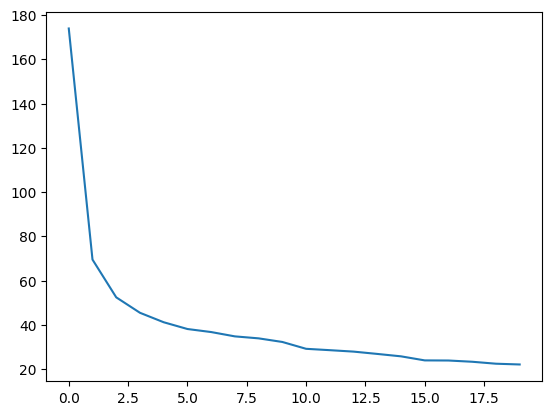

In [ ]:
max_model = CNN_8Layer_Max(10).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q1/MaxPool', benchmark=True)
trainer.fit(max_model, train_MNIST)
max_model.loss_graph()
del trainer, max_model

100%|██████████| 10000/10000 [00:17<00:00, 574.25it/s]


Confusion Matrix:



100%|██████████| 10000/10000 [00:00<00:00, 303231.93it/s]


[[201   0   5   6   1   2  10   0  12   3]
 [  0 104   5   0   1   0   4   2   0   2]
 [  0   3 236   8   1   1   2   9   5   1]
 [  1   0   0 198   0   6   0   0   0   3]
 [  0   2   5   0 202   0   6   1   0   9]
 [  1   0   0  13   0 106   2   0   2   8]
 [  3   1   1   1   0   8 163   0   2   0]
 [  3   0   8   8   3   0   0 243   5  12]
 [  0   1   3   2   0   0   3   1 176   1]
 [  3   0   1   6   6   1   0   4   4 202]]

Overall Accuracy =  97.67 %

Class-Wise Accuracies =  [[98.87755102 99.38325991 97.28682171 95.64356436 98.77800407 97.98206278
  97.18162839 98.3463035  96.91991786 96.13478692]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1008
           1       0.99      0.99      0.99      1142
           2       0.97      0.97      0.97      1034
           3       0.96      0.99      0.97       976
           4       0.99      0.98      0.98       993
           5       0.98      0.97      0.98       900
         

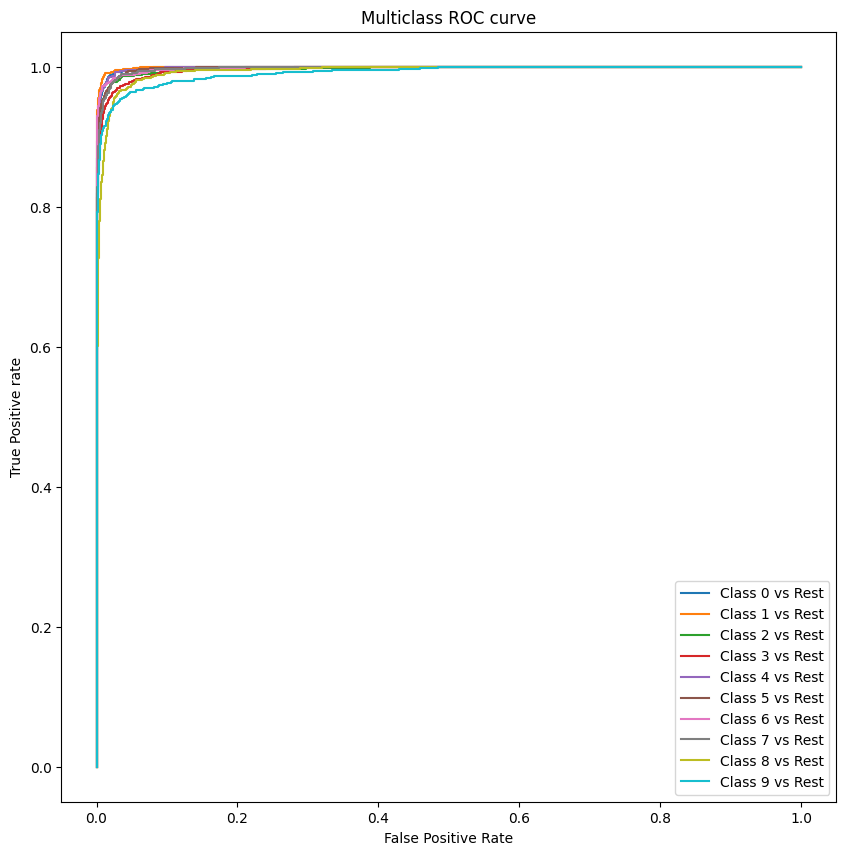

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Assignment_4/Q1/MaxPool/lightning_logs/version_1/checkpoints/epoch=19-step=12000.ckpt', CNN_8Layer_Max(10))
detect(test_MNIST, Model_Test)
del Model_Test

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 525 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
525 K     Trainable params
0         Non-trainable params
525 K     Total params
2.104     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


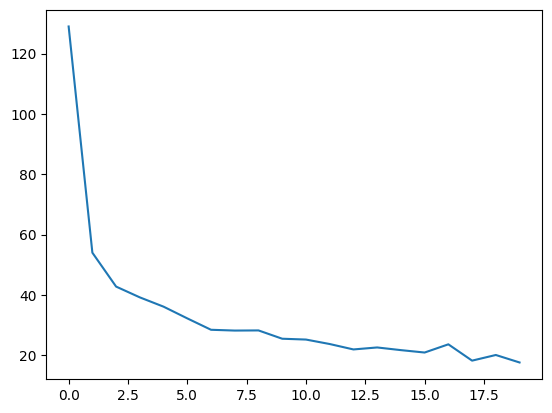

In [ ]:
LP_model = CNN_8Layer_Power(10).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q1/LPPool', benchmark=True)
trainer.fit(LP_model, train_MNIST)
LP_model.loss_graph()
del trainer, LP_model

100%|██████████| 10000/10000 [00:19<00:00, 505.21it/s]


Confusion Matrix:



100%|██████████| 10000/10000 [00:00<00:00, 272299.05it/s]


[[210   0   2   0   4   2   7   1   8   3]
 [  0 110   3   0   2   0   4   3   1   3]
 [  0   1 251   4   0   0   1   3   2   0]
 [  0   0   0 230   0   3   1   2   1   1]
 [  0   0   0   0 171   0   1   0   0   1]
 [  0   0   0   4   0 114   1   0   0   3]
 [  0   0   0   0   5   3 171   0   1   1]
 [  1   0   5   0   3   1   0 249   0   7]
 [  1   0   3   4   5   1   4   1 191   8]
 [  0   0   0   0  24   0   0   1   2 214]]

Overall Accuracy =  98.47 %

Class-Wise Accuracies =  [[99.79591837 99.91189427 98.74031008 98.81188119 95.62118126 98.87892377
  98.01670146 98.92996109 98.45995893 97.32408325]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1005
           1       1.00      0.99      0.99      1150
           2       0.99      0.99      0.99      1030
           3       0.99      0.99      0.99      1006
           4       0.96      1.00      0.98       941
           5       0.99      0.99      0.99       890
         

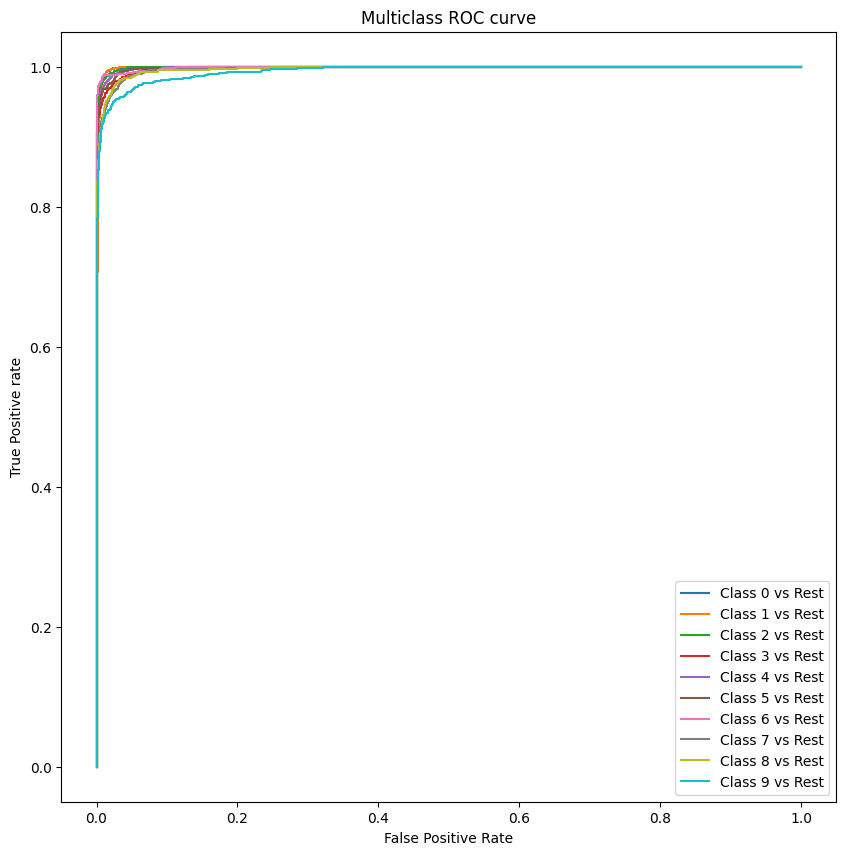

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Assignment_4/Q1/LPPool/lightning_logs/version_0/checkpoints/epoch=19-step=12000.ckpt', CNN_8Layer_Power(10))
detect(test_MNIST, Model_Test)
del Model_Test

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | Sequential       | 525 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
525 K     Trainable params
0         Non-trainable params
525 K     Total params
2.104     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


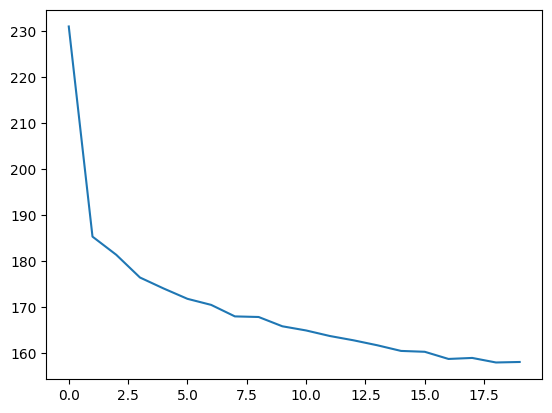

In [ ]:
avg_model = CNN_8Layer_Avg(10).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q1/AvgPool', benchmark=True)
trainer.fit(avg_model, train_MNIST)
avg_model.loss_graph()
del trainer, avg_model

100%|██████████| 10000/10000 [00:13<00:00, 720.61it/s]


Confusion Matrix:



100%|██████████| 10000/10000 [00:00<00:00, 279827.34it/s]


[[199   0   9   5   1  11   8   2  11  13]
 [  0  93  11   1   2   3   3   9  10   7]
 [  1   5 169  32   9   8  11  28   9   1]
 [  1   1   6 125   2  31   1   3  13   9]
 [  1   1   8   1 160   9   6  13  10  47]
 [  5   1   4  29   0  17  28   2  27   4]
 [  3   3   9   3   7   8 129   0   8   0]
 [  1   1   7  10   1   6   1 169   8  18]
 [  1   6  37  30   9  25   3   2 103  10]
 [  0   0   4   6  23   6   0  32   7 132]]

Overall Accuracy =  92.32 %

Class-Wise Accuracies =  [[98.67346939 98.41409692 90.79457364 88.41584158 94.50101833 88.0044843
  93.63256785 91.14785992 89.42505133 89.19722498]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1027
           1       0.98      0.96      0.97      1163
           2       0.91      0.90      0.90      1041
           3       0.88      0.93      0.91       960
           4       0.95      0.91      0.93      1024
           5       0.88      0.89      0.88       885
          

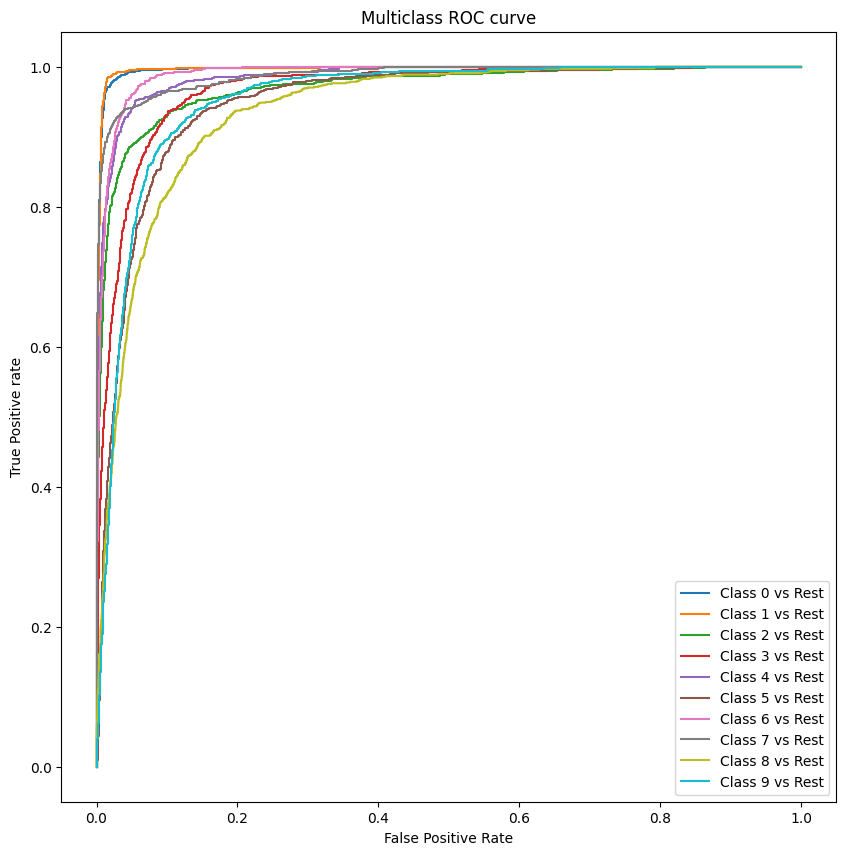

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Assignment_4/Q1/AvgPool/lightning_logs/version_0/checkpoints/epoch=19-step=12000.ckpt', CNN_8Layer_Avg(10))
detect(test_MNIST, Model_Test)
del Model_Test

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


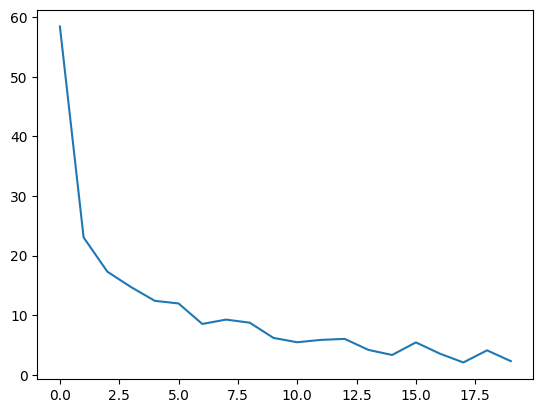

In [ ]:
resnet = Model(10).train().cuda()
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q1/ResNet18', benchmark=True)
trainer.fit(resnet, train_MNIST)
resnet.loss_graph()
del trainer, resnet


100%|██████████| 10000/10000 [00:55<00:00, 180.25it/s]


Confusion Matrix:




100%|██████████| 10000/10000 [00:00<00:00, 248804.94it/s]


[[210   0   1   0   0   0   3   0   2   0]
 [  0 109   1   0   0   0   2   3   0   0]
 [  0   0   2   0   1   0   0   4   2   0]
 [  0   1   1 238   0   1   0   0   1   1]
 [  0   0   0   0 209   0   0   0   0   4]
 [  0   0   0   4   0 122   1   0   0   2]
 [  1   0   0   0   0   1 182   0   0   0]
 [  1   1   3   0   0   0   0 253   0   2]
 [  0   0   0   0   0   0   2   0 200   3]
 [  0   0   0   0   4   0   0   0   1 229]]

Overall Accuracy =  99.46 %

Class-Wise Accuracies =  [[99.79591837 99.82378855 99.41860465 99.6039604  99.49083503 99.77578475
  99.16492693 99.31906615 99.38398357 98.81070367]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       984
           1       1.00      0.99      1.00      1139
           2       0.99      0.99      0.99      1033
           3       1.00      1.00      1.00      1011
           4       0.99      1.00      1.00       981
           5       1.00      0.99      0.99       897
         

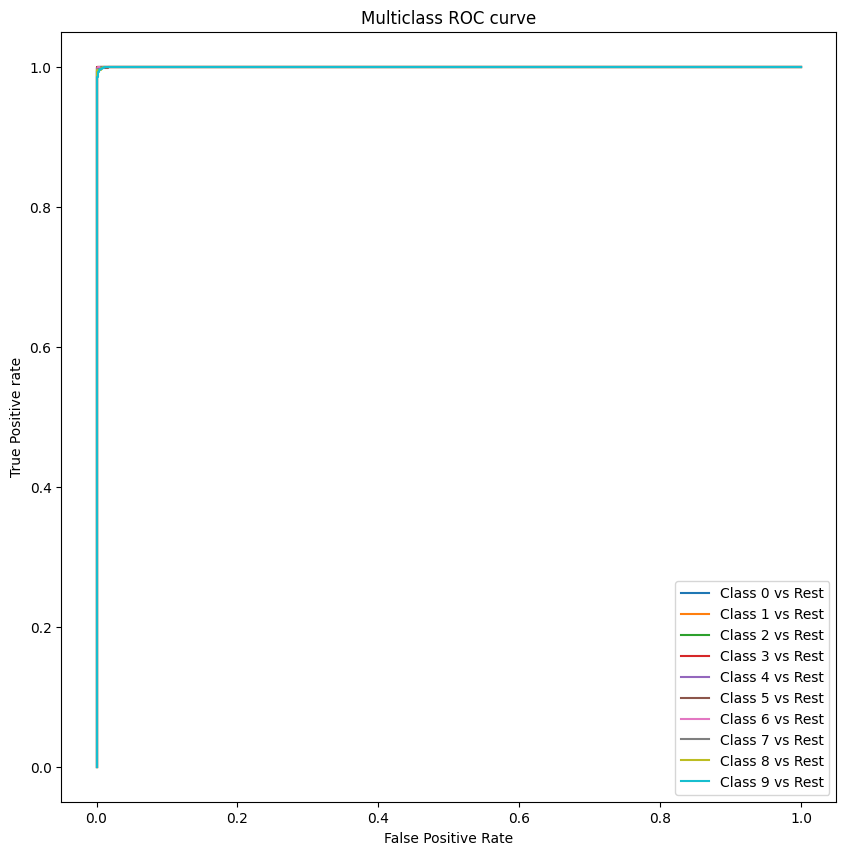

In [ ]:
Model_Test = model_return('/content/drive/MyDrive/CV_Assignment_4/Q1/ResNet18/lightning_logs/version_1/checkpoints/epoch=19-step=12000.ckpt', Model(10))
detect(test_MNIST, Model_Test)
del Model_Test

#Question-2

In [ ]:
class CaptionVectorizer:
  def __init__(self, vocab, bos_token='<bos>', eos_token='<eos>', unk_token='<unk>'):
    self.vocab = vocab
    self.bos_token = bos_token
    self.eos_token = eos_token
    self.unk_token = unk_token
    self.bos_index = self.vocab.get(bos_token, len(self.vocab))
    if self.bos_index == len(self.vocab):
      self.vocab[bos_token] = self.bos_index
    self.eos_index = self.vocab.get(eos_token, len(self.vocab))
    if self.eos_index == len(self.vocab):
      self.vocab[eos_token] = self.eos_index
    self.unk_index = self.vocab.get(unk_token, len(self.vocab))
    if self.unk_index == len(self.vocab):
      self.vocab[unk_token] = self.unk_index

  def __call__(self, caption):
    caption = re.sub(r'http\S+', '', caption)
    caption = caption.lower().translate(str.maketrans('', '', string.punctuation))
    caption = ''.join([i for i in caption if not i.isdigit()])
    words = caption.split()
    indices = [self.bos_index]
    for word in words:
      if word in self.vocab:
        indices.append(self.vocab[word])
      else:
        indices.append(self.unk_index)
    indices.append(self.eos_index)
    return torch.LongTensor(indices)

  def return_vocab(self):
    return self.vocab

  def get_token_from_index(self, index):
    for token, idx in self.vocab.items():
      if idx == index:
        return token
    return self.unk_token

class creator(Dataset):
  def __init__(self, img_dir, dataframe, caption_vectorizer):
    self.img_dir = img_dir 
    self.dataframe = dataframe
    self.caption_vectorizer = caption_vectorizer

  def __getitem__(self, idx):
    self.img_name = self.dataframe.iloc[idx]['images']
    self.img_caption = self.dataframe.iloc[idx]['captions']
    self.img_path = os.path.join(self.img_dir,self.img_name)
    self.img = cv2.imread(self.img_path)
    if self.img is not None:
      self.img = cv2.resize(self.img,(224,224))
      self.vector = self.caption_vectorizer(self.img_caption)
      return transforms.ToTensor()(self.img), self.vector

  def __len__(self):
    return self.dataframe.shape[0]

class EncoderDecoder(pl.LightningModule):
  def __init__(self, cnn_name, mode, hidden_dim, output_dim, vocab_size):
    '''
    input_dim = number of channels (input to CNN)
    vocab_size = size of vocabulary (input to RNN's embedding layer)
    output_dim = number of classes (within vocabulary)
    '''
    super().__init__()
    self.loss=[]
    self.encoder_name = cnn_name
    self.mode = mode
    if self.encoder_name=='resnet_34' and self.mode=='Train':
      self.encoder = models.resnet34(weights='IMAGENET1K_V1')
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features
    if self.encoder_name=='convnext_tiny' and self.mode=='Train':
      self.encoder = models.convnext_tiny(weights='IMAGENET1K_V1')
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features 
    if self.encoder_name=='mnasnet0_5' and self.mode=='Train':
      self.encoder = models.mnasnet0_5(weights='IMAGENET1K_V1')
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features 
    if self.encoder_name=='regnet_y_400mf' and self.mode=='Train':
      self.encoder = models.regnet_y_400mf(weights='IMAGENET1K_V1')
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features 
    if self.encoder_name=='resnext50_32x4d' and self.mode=='Train':
      self.encoder = models.resnext50_32x4d(weights='IMAGENET1K_V1')
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features 
    if self.encoder_name=='shufflenet_v2_x0_5' and self.mode=='Train':
      self.encoder = models.shufflenet_v2_x0_5(weights='IMAGENET1K_V1')
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features 
    if self.encoder_name=='squeezenet1_0' and self.mode=='Train':
      self.encoder = models.squeezenet1_0(weights='IMAGENET1K_V1')
      self.features = self.encoder.classifier[-3].in_channels
      self.out = self.encoder.classifier[-3].out_channels
    if self.encoder_name=='vgg11' and self.mode=='Train':
      self.encoder = models.vgg11(weights='IMAGENET1K_V1')
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features 
    if self.encoder_name=='wide_resnet50_2' and self.mode=='Train':
      self.encoder = models.wide_resnet50_2(weights='IMAGENET1K_V1')
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features 
    if self.encoder_name=='swin_t' and self.mode=='Train':
      self.encoder = models.swin_t(weights='IMAGENET1K_V1')
      self.features = self.encoder.head.in_features
      self.out = self.encoder.head.out_features
    if self.encoder_name=='densenet_121' and self.mode=='Train':
      self.encoder = models.densenet121(weights='IMAGENET1K_V1')
      self.features = self.encoder.classifier.in_features
      self.out = self.encoder.classifier.out_features
    if self.encoder_name=='efficientnet_b0' and self.mode=='Train':
      self.encoder = models.efficientnet.efficientnet_b0(weights='IMAGENET1K_V1')
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features
    if self.encoder_name=='mobilenet_v3_large' and self.mode=='Train':
      self.encoder = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features
    if self.encoder_name=='resnet_34' and self.mode=='Test':
      self.encoder = models.resnet34(weights=None)
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features
    if self.encoder_name=='convnext_tiny' and self.mode=='Test':
      self.encoder = models.convnext_tiny(weights=None)
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features 
    if self.encoder_name=='mnasnet0_5' and self.mode=='Test':
      self.encoder = models.mnasnet0_5(weights=None)
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features 
    if self.encoder_name=='regnet_y_400mf' and self.mode=='Test':
      self.encoder = models.regnet_y_400mf(weights=None)
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features 
    if self.encoder_name=='resnext50_32x4d' and self.mode=='Test':
      self.encoder = models.resnext50_32x4d(weights=None)
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features 
    if self.encoder_name=='shufflenet_v2_x0_5' and self.mode=='Test':
      self.encoder = models.shufflenet_v2_x0_5(weights=None)
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features 
    if self.encoder_name=='squeezenet1_0' and self.mode=='Test':
      self.encoder = models.squeezenet1_0(weights=None)
      self.features = self.encoder.classifier[-3].in_channels
      self.out = self.encoder.classifier[-3].out_channels
    if self.encoder_name=='vgg11' and self.mode=='Test':
      self.encoder = models.vgg11(weights=None)
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features 
    if self.encoder_name=='wide_resnet50_2' and self.mode=='Test':
      self.encoder = models.wide_resnet50_2(weights=None)
      self.features = self.encoder.fc.in_features
      self.out = self.encoder.fc.out_features 
    if self.encoder_name=='swin_t' and self.mode=='Test':
      self.encoder = models.swin_t(weights=None)
      self.features = self.encoder.head.in_features
      self.out = self.encoder.head.out_features
    if self.encoder_name=='densenet_121' and self.mode=='Test':
      self.encoder = models.densenet121(weights=None)
      self.features = self.encoder.classifier.in_features
      self.out = self.encoder.classifier.out_features
    if self.encoder_name=='efficientnet_b0' and self.mode=='Test':
      self.encoder = models.efficientnet.efficientnet_b0(weights=None)
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features
    if self.encoder_name=='mobilenet_v3_large' and self.mode=='Test':
      self.encoder = models.mobilenet_v3_large(weights=None)
      self.features = self.encoder.classifier[-1].in_features 
      self.out = self.encoder.classifier[-1].out_features
    for name, param in self.encoder.named_parameters():
        param.requires_grad = False
    self.embedding = nn.Embedding(vocab_size, self.out)
    self.decoder = nn.LSTM(2*self.out, hidden_dim, num_layers=1, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.vocab_size = vocab_size
    self.loss_fn = nn.CrossEntropyLoss(ignore_index=0)

  def forward(self, image, caption):
    caption = self.embedding(caption)
    image = self.encoder(image)
    image = image.unsqueeze(1).repeat(1, caption.size(1), 1)
    inputs = torch.cat((caption, image), dim=2)
    outputs, _ = self.decoder(inputs)
    outputs = self.fc(outputs)
    return outputs

  def training_step(self, batch, batch_idx):
    images, captions = batch
    outputs = self(images, captions[:,:-1])
    loss = self.loss_fn(outputs.reshape(outputs.shape[0]*outputs.shape[1], self.vocab_size-1), captions[:,1:].reshape(-1))
    if batch_idx==1874:
      print(loss)
    return loss

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

In [ ]:
def create(images_file=None, token_file=None):
  token_files = []
  token_captions = []
  if token_file is not None:
    with open(token_file, 'r') as f:
      for line in f:
        image_name, caption_text = line.strip().split('\t')
        image_name = image_name.split('#')[0]
        token_files.append(image_name)
        token_captions.append(caption_text)
  with open(images_file, 'r') as f:
    image_list = f.read().splitlines()
  return image_list, token_files, token_captions

def return_dataframe(reference_list, imgs, captions):
  token_imgs = []
  token_captions = []
  for item in reference_list:
    for img_index in range(len(imgs)):
      if imgs[img_index]==item:
        token_imgs.append(item)
        token_captions.append(captions[img_index])
  df = pd.DataFrame()
  df['images']=token_imgs
  df['captions']=token_captions
  return df

def collate_fn(data):
  images, captions = zip(*data)
  captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=0)
  return torch.stack(images), captions

def generate_caption(model, image_tensor, caption_vectorizer):
  model.eval().cuda()
  with torch.no_grad():
    features = model.encoder(image_tensor)
    features = features.unsqueeze(1)
    inputs = torch.LongTensor([[caption_vectorizer.bos_index]]).cuda()
    caption = []
    MAX_SEQ_LEN = 20
    for i in range(MAX_SEQ_LEN):
      caption.append(inputs.item())
      embeddings = model.embedding(inputs)
      inputs = torch.cat((features, embeddings), dim=2)
      outputs, hidden = model.decoder(inputs)
      predicted = outputs.argmax(-1)[:,-1]
      if predicted.item() == caption_vectorizer.eos_index:
        break
      inputs = predicted.unsqueeze(1)
  caption = [caption_vectorizer.get_token_from_index(w) for w in caption]
  return image_tensor.detach().cpu().numpy(), ' '.join(caption)

In [ ]:
#cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
#!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
#!unzip Flickr8k_Dataset.zip
#!unzip Flickr8k_text.zip

In [ ]:
'''train_imgs, token_imgs , token_captions = create('/content/drive/MyDrive/CV_Assignment_4/Q2/Flickr_8k.trainImages.txt','/content/drive/MyDrive/CV_Assignment_4/Q2/Flickr8k.token.txt')
test_imgs, _, _ = create('/content/drive/MyDrive/CV_Assignment_4/Q2/Flickr_8k.testImages.txt',None)
df_train = return_dataframe(train_imgs, token_imgs, token_captions)
df_test = return_dataframe(test_imgs, token_imgs, token_captions)
df_train.to_csv('/content/drive/MyDrive/CV_Assignment_4/Q2/train_dataframe.csv')
df_test.to_csv('/content/drive/MyDrive/CV_Assignment_4/Q2/test_dataframe.csv')'''

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/CV_Assignment_4/Q2/train_dataframe.csv')

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/CV_Assignment_4/Q2/test_dataframe.csv')

In [ ]:
df_train_list = df_train['captions'].to_list()
vocabulary={}
for caption in df_train_list:
  caption = re.sub(r'http\S+', '', caption)
  caption = caption.lower().translate(str.maketrans('', '', string.punctuation))
  caption = ''.join([i for i in caption if not i.isdigit()])
  words = caption.split()
  for word in words:
    if word not in vocabulary:
      vocabulary[word] = len(vocabulary)
caption_vectorizer = CaptionVectorizer(vocabulary)
print(len(caption_vectorizer.return_vocab().keys()))
print(caption_vectorizer.return_vocab())

7593
{'a': 0, 'black': 1, 'dog': 2, 'is': 3, 'running': 4, 'after': 5, 'white': 6, 'in': 7, 'the': 8, 'snow': 9, 'chasing': 10, 'brown': 11, 'through': 12, 'two': 13, 'dogs': 14, 'chase': 15, 'each': 16, 'other': 17, 'across': 18, 'snowy': 19, 'ground': 20, 'play': 21, 'together': 22, 'low': 23, 'lying': 24, 'body': 25, 'of': 26, 'water': 27, 'little': 28, 'baby': 29, 'plays': 30, 'croquet': 31, 'girl': 32, 'next': 33, 'to': 34, 'truck': 35, 'child': 36, 'playing': 37, 'croquette': 38, 'by': 39, 'kid': 40, 'front': 41, 'car': 42, 'with': 43, 'put': 44, 'and': 45, 'ball': 46, 'boy': 47, 'hammer': 48, 'beside': 49, 'has': 50, 'something': 51, 'hot': 52, 'pink': 53, 'its': 54, 'mouth': 55, 'holding': 56, 'hat': 57, 'shirt': 58, 'carrying': 59, 'while': 60, 'walking': 61, 'looking': 62, 'forward': 63, 'along': 64, 'beach': 65, 'wearing': 66, 'collar': 67, 'walks': 68, 'on': 69, 'sand': 70, 'near': 71, 'large': 72, 'ocean': 73, 'red': 74, 'frisbee': 75, 'standing': 76, 'sandy': 77, 'drops':

In [ ]:
#CV_Assignment_4/Q2/
train_dataset = creator('/content/drive/MyDrive/CV_Assignment_4/Q2/Flicker8k_Dataset',df_train, caption_vectorizer)
test_dataset = creator('/content/drive/MyDrive/CV_Assignment_4/Q2/Flicker8k_Dataset',df_test, caption_vectorizer)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn, num_workers=1, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

## Training Models

### Squeezenet1_0

In [ ]:
model = EncoderDecoder(cnn_name='squeezenet1_0', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=10, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Models/squeezenet1_0/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | encoder   | SqueezeNet       | 1.2 M 
1 | embedding | Embedding        | 7.6 M 
2 | decoder   | LSTM             | 5.1 M 
3 | fc        | Line

Training: 0it [00:00, ?it/s]

tensor(5.8884, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.8153, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.6648, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4864, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.8275, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.3998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.6252, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.4792, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.5389, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(5.6168, device='cuda:0', grad_fn=<NllLossBackward0>)


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Resnet_34

In [ ]:
model = EncoderDecoder(cnn_name='resnet_34', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=10, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Models/resnet_34/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

In [ ]:
model = EncoderDecoder(cnn_name='resnet_34', hidden_dim=512, mode='Train', output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=50, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q2/Models/resnet_34/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | encoder   | ResNet           | 21.8 M
1 | embedding | Embedding        | 7.6 M 
2 | decoder   | LSTM             | 5.1 M 
3 | fc        | Line

Training: 0it [00:00, ?it/s]

tensor(4.0721, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0406, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9203, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8374, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3418, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0439, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5951, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2830, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2680, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0499, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8555, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0744, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6879, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6641, device='cuda:0', grad_fn=

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


### Swin_t

In [ ]:
model = EncoderDecoder(cnn_name='swin_t', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=10, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q2/Models/swin_t/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth

  0%|          | 0.00/108M [00:00<?, ?B/s]
  0%|          | 16.0k/108M [00:00<22:06, 85.5kB/s]
  0%|          | 56.0k/108M [00:00<12:26, 152kB/s] 
  0%|          | 136k/108M [00:00<06:48, 277kB/s] 
  0%|          | 312k/108M [00:00<03:39, 515kB/s]
  1%|          | 648k/108M [00:01<02:01, 927kB/s]
  1%|          | 1.28M/108M [00:01<01:05, 1.72MB/s]
  2%|▏         | 2.59M/108M [00:01<00:33, 3.30MB/s]
  5%|▍         | 5.18M/108M [00:01<00:14, 7.52MB/s]
  6%|▌         | 6.14M/108M [00:01<00:14, 7.56MB/s]
  8%|▊         | 8.95M/108M [00:01<00:10, 9.96MB/s]
 11%|█▏        | 12.3M/108M [00:02<00:08, 12.3MB/s]
 15%|█▍        | 16.0M/108M [00:02<00:06, 14.3MB/s]
 18%|█▊        | 19.8M/108M [00:02<00:05, 15.7MB/s]
 22%|██▏       | 23.6M/108M [00:02<00:05, 16.5MB/s]
 25%|██▌       | 27.4M/108M [00:02<00:04, 17.2MB/s]
 29%|██▉       | 31.3M/108M [00:03<00:04, 17.7MB/s]


Training: 0it [00:00, ?it/s]

tensor(3.3293, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7394, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3709, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4575, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0194, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7727, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1761, device='cuda:0', grad_fn=<NllLossBackward0>)


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### MobileNet_v3_large

In [ ]:
model = EncoderDecoder(cnn_name='mobilenet_v3_large', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=10, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q2/Models/mobilenet_v3_large/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | encoder   | MobileNetV3      | 5.5 M 
1 | embedding | Embedding        | 7.6 M 
2 | decoder   | LSTM             | 5.1 M 
3 | fc        | Line

Training: 0it [00:00, ?it/s]

tensor(3.7041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3254, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1940, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7415, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8291, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3643, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8234, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6678, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2909, device='cuda:0', grad_fn=<NllLossBackward0>)


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### Densenet_121

In [ ]:
model = EncoderDecoder(cnn_name='densenet_121', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=10, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q2/Models/densenet_121/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth

  0%|          | 0.00/30.8M [00:00<?, ?B/s]
 32%|███▏      | 9.74M/30.8M [00:00<00:00, 102MB/s]
 63%|██████▎   | 19.5M/30.8M [00:00<00:00, 101MB/s]
100%|██████████| 30.8M/30.8M [00:00<00:00, 101MB/s]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | encoder   | DenseNet    

Training: 0it [00:00, ?it/s]

tensor(3.9833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4584, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1117, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4725, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1996, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0862, device='cuda:0', grad_fn=<NllLossBackward0>)


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
model = EncoderDecoder(cnn_name='densenet_121', hidden_dim=512, mode='Train', output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=50, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Models/densenet_121/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 72.3MB/s]
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:562: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
--

Training: 0it [00:00, ?it/s]

tensor(3.5483, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9558, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6324, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4933, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5951, device='cuda:0', grad_fn=<NllLossBackward0>)


### VGG_11

In [ ]:
model = EncoderDecoder(cnn_name='vgg11', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=10, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q2/Models/vgg11/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth

  0%|          | 0.00/507M [00:00<?, ?B/s]
  2%|▏         | 9.56M/507M [00:00<00:05, 100MB/s]
  4%|▍         | 19.1M/507M [00:00<00:05, 98.9MB/s]
  6%|▌         | 28.5M/507M [00:00<00:06, 81.2MB/s]
  7%|▋         | 37.6M/507M [00:00<00:05, 84.2MB/s]
  9%|▉         | 46.5M/507M [00:00<00:05, 87.3MB/s]
 11%|█         | 55.7M/507M [00:00<00:05, 90.0MB/s]
 13%|█▎        | 64.5M/507M [00:00<00:05, 90.8MB/s]
 14%|█▍        | 73.3M/507M [00:00<00:05, 90.2MB/s]
 16%|█▋        | 83.1M/507M [00:00<00:04, 94.1MB/s]
 18%|█▊        | 92.1M/507M [00:01<00:04, 92.5MB/s]
 20%|██        | 102M/507M [00:01<00:04, 94.5MB/s] 
 22%|██▏       | 111M/507M [00:01<00:04, 94.1MB/s]
 24%|██▎       | 120M/507M [00:01<00:04, 94.9MB/s]
 25%|██▌       | 129M/507M [00:01<00:04, 94.5MB/s]
 27%|██▋       | 138M/507M [00:01<00:04, 95.7MB/s]
 29%|██▉       | 148M/507M [00:01<00:04, 94.2MB/s]
 31

Training: 0it [00:00, ?it/s]

tensor(4.5839, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.8612, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1341, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8745, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6183, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8502, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8304, device='cuda:0', grad_fn=<NllLossBackward0>)


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
model = EncoderDecoder(cnn_name='vgg11', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=50, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q2/Models/vgg11/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

### EfficientNet_B0

In [ ]:
model = EncoderDecoder(cnn_name='efficientnet_b0', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab))
trainer = pl.Trainer(accelerator='gpu', precision=16, max_epochs=10, default_root_dir='/content/drive/MyDrive/CV_Assignment_4/Q2/Models/efficientnet_b0/', benchmark=True)
trainer.fit(model, train_loader)
del model, trainer

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth

  0%|          | 0.00/20.5M [00:00<?, ?B/s]
 49%|████▊     | 9.96M/20.5M [00:00<00:00, 104MB/s]
100%|██████████| 20.5M/20.5M [00:00<00:00, 97.7MB/s]
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | encoder   | EfficientNet     | 5.3 M 
1 | embed

Training: 0it [00:00, ?it/s]

tensor(3.6268, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1850, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1729, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3982, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4636, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1985, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0993, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9458, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7365, device='cuda:0', grad_fn=<NllLossBackward0>)


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Seeing Captions on the Models

<bos> trees bookcase trees bookcase trees bookcase trees bookcase trees bookcase trees bookcase trees bookcase trees bookcase trees bookcase trees


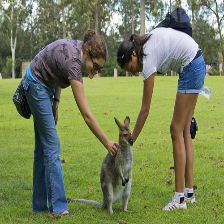

In [ ]:
imgo = 0
for i,j in test_loader:
  imgo = i.cuda()
  break

model = model_return('/content/drive/MyDrive/CV_Assignment_4/Q2/Models/squeezenet1_0/lightning_logs/version_0/checkpoints/epoch=9-step=18750.ckpt',EncoderDecoder(cnn_name='squeezenet1_0', mode='Test', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab)))
img, caption = generate_caption(model, imgo, caption_vectorizer)
print(caption)
cv2_imshow(img[0].transpose((1,2,0))*255)

<bos> nine ractrack nine ractrack nine ractrack nine ractrack nine ractrack nine ractrack nine ractrack nine ractrack nine ractrack nine


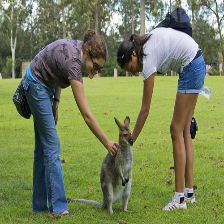

In [ ]:
model = model_return('/content/drive/MyDrive/CV_Assignment_4/Q2/Models/densenet_121/lightning_logs/version_0/checkpoints/epoch=9-step=18750.ckpt',EncoderDecoder(cnn_name='densenet_121', mode='Test', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab)))
img, caption = generate_caption(model, imgo, caption_vectorizer)
print(caption)
cv2_imshow(img[0].transpose((1,2,0))*255)

<bos> sit up climbing climbing climbing climbing climbing climbing climbing climbing climbing climbing climbing climbing climbing climbing climbing climbing climbing


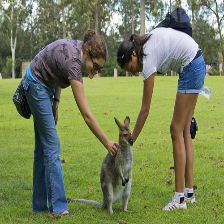

In [ ]:
model = model_return('/content/drive/MyDrive/CV_Assignment_4/Q2/Models/efficientnet_b0/lightning_logs/version_0/checkpoints/epoch=9-step=18750.ckpt',EncoderDecoder(cnn_name='efficientnet_b0', mode='Test', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab)))
img, caption = generate_caption(model, imgo, caption_vectorizer)
print(caption)
cv2_imshow(img[0].transpose((1,2,0))*255)

<bos> beach bicycle chaps running chainmail doing running chainmail doing running chainmail doing running chainmail doing running chainmail doing running


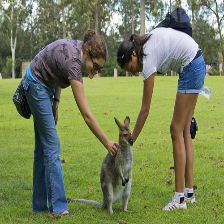

In [ ]:
model = model_return('/content/drive/MyDrive/CV_Assignment_4/Q2/Models/mobilenet_v3_large/lightning_logs/version_1/checkpoints/epoch=9-step=18750.ckpt',EncoderDecoder(cnn_name='mobilenet_v3_large', mode='Test', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab)))
img, caption = generate_caption(model, imgo, caption_vectorizer)
print(caption)
cv2_imshow(img[0].transpose((1,2,0))*255)

<bos> beach of pink of pink of pink of pink of pink of pink of pink of pink of pink


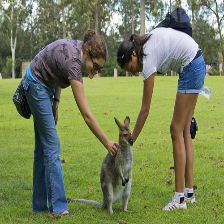

In [ ]:
model = model_return('/content/drive/MyDrive/CV_Assignment_4/Q2/Models/resnet_34/lightning_logs/version_1/checkpoints/epoch=49-step=93750.ckpt',EncoderDecoder(cnn_name='resnet_34', mode='Test', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab)))
img, caption = generate_caption(model, imgo, caption_vectorizer)
print(caption)
cv2_imshow(img[0].transpose((1,2,0))*255)

<bos> passing mantle shallow woman devices he white from denim toy palying photograph white from denim toy palying photograph white


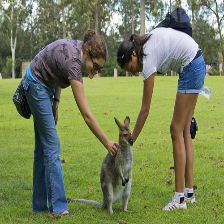

In [ ]:
model = model_return('/content/drive/MyDrive/CV_Assignment_4/Q2/Models/swin_t/lightning_logs/version_0/checkpoints/epoch=9-step=18750.ckpt',EncoderDecoder(cnn_name='swin_t', mode='Test', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab)))
img, caption = generate_caption(model, imgo, caption_vectorizer)
print(caption)
cv2_imshow(img[0].transpose((1,2,0))*255)

<bos> brick old old old old old old old old old old old old old old old old old old


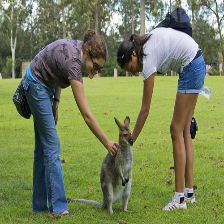

In [ ]:
model = model_return('/content/drive/MyDrive/CV_Assignment_4/Q2/Models/vgg11/lightning_logs/version_0/checkpoints/epoch=9-step=18750.ckpt',EncoderDecoder(cnn_name='vgg11', mode='Test', hidden_dim=512, output_dim=caption_vectorizer.unk_index, vocab_size=len(caption_vectorizer.vocab)))
img, caption = generate_caption(model, imgo, caption_vectorizer)
print(caption)
cv2_imshow(img[0].transpose((1,2,0))*255)

# Question-3

In [ ]:
#!wget https://pjreddie.com/media/files/yolov3-tiny.weights

In [ ]:
#!wget https://pjreddie.com/media/files/yolov3.weights

In [ ]:
#!wget https://pjreddie.com/media/files/yolov2-tiny.weights

--2023-05-06 19:14:20--  https://pjreddie.com/media/files/yolov2-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44948600 (43M) [application/octet-stream]
Saving to: ‘yolov2-tiny.weights’

yolov2-tiny.weights 100%[===================>]  42.87M  19.9MB/s    in 2.2s    

2023-05-06 19:14:22 (19.9 MB/s) - ‘yolov2-tiny.weights’ saved [44948600/44948600]



In [ ]:
#!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15514, done.
remote: Total 15514 (delta 0), reused 0 (delta 0), pack-reused 15514
Receiving objects: 100% (15514/15514), 14.18 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (10412/10412), done.


In [ ]:
#cd darknet

/content/darknet


In [ ]:
#!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 0)
      |      

In [ ]:
#!cp -r /content/darknet /content/drive/MyDrive/CV_Assignment_4/Q3/darknet_template

In [ ]:
#!cp -r /content/drive/MyDrive/CV_Assignment_4/Q3/darknet_template /content/darknet

In [ ]:
!chmod +x ./drive/MyDrive/CV_Assignment_4/Q3/darknet_template/darknet

In [ ]:
cd /content/drive/MyDrive/CV_Assignment_4/Q3/darknet_template

/content/drive/MyDrive/CV_Assignment_4/Q3/darknet_template


## Yolov3-tiny

In [ ]:
! ./darknet detector train data/deer.data cfg/yolov3-tiny_deer.cfg yolov3-tiny.weights -map -dont_show -mjpeg_port 8090 -map_visual -clear 

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 14 Avg (IOU: 0.000000), count: 1, class_loss = 0.231035, iou_loss = 0.000000, total_loss = 0.231035 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 21 Avg (IOU: 0.724491), count: 2, class_loss = 0.197556, iou_loss = 0.347552, total_loss = 0.545108 
 total_bbox = 328934, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 14 Avg (IOU: 0.000000), count: 1, class_loss = 0.231035, iou_loss = 0.000000, total_loss = 0.231035 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 21 Avg (IOU: 0.340749), count: 1, class_loss = 0.964787, iou_loss = 0.967379, total_loss = 1.932165 
 total_bbox = 328935, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 14 Avg (IOU: 0.000000), count: 1, class_loss = 0.231035, iou_loss = 0.000000, total_loss = 0.231035 
v3 (mse

### Threshold=0.05

In [ ]:
! ./darknet detector test data/deer.data cfg/yolov3-tiny_deer.cfg backup/yolov3-tiny_deer_best.weights -dont_show -thresh 0.05 -ext_output -out > results_3tiny_005.txt

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot 

## Yolov3-320

In [ ]:
! ./darknet detector train data/deer.data cfg/yolov3_deer.cfg yolov3.weights -map -dont_show -mjpeg_port 8090 -map_visual -clear 

Streaming output truncated to the last 5000 lines.
 total_bbox = 240, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.007274, iou_loss = 0.000000, total_loss = 0.007274 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 327.516327, iou_loss = 0.000000, total_loss = 327.516327 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 8.954366, iou_loss = 0.000000, total_loss = 8.954366 
 total_bbox = 240, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.002650, iou_loss = 0.000000, total_loss = 0.002650 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.000000), count: 1, class_loss = 327.426178, iou_loss = 0.000000, total_loss = 327.426178 
v3 (

### Threshold=0.1

In [ ]:
! ./darknet detector test data/deer.data cfg/yolov3_deer.cfg backup/yolov3_deer_last.weights -dont_show -thresh 0.1 -ext_output -out > results_3_01.txt

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot 

## Yolov2-tiny

In [ ]:
! ./darknet detector train data/deer.data cfg/yolov2-tiny_deer.cfg yolov2-tiny.weights -map -dont_show -mjpeg_port 8090 -map_visual -clear 

Streaming output truncated to the last 5000 lines.
Region Avg IOU: 0.754604, Class: 1.000000, Obj: 0.823757, No Obj: 0.002171, Avg Recall: 1.000000,  count: 3
Region Avg IOU: 0.837586, Class: 1.000000, Obj: 0.996358, No Obj: 0.000706, Avg Recall: 1.000000,  count: 1
Region Avg IOU: 0.911335, Class: 1.000000, Obj: 0.991728, No Obj: 0.000540, Avg Recall: 1.000000,  count: 1
Region Avg IOU: 0.830969, Class: 1.000000, Obj: 0.997675, No Obj: 0.000849, Avg Recall: 1.000000,  count: 2
Region Avg IOU: 0.737745, Class: 1.000000, Obj: 0.989017, No Obj: 0.001682, Avg Recall: 1.000000,  count: 1
Region Avg IOU: 0.814082, Class: 1.000000, Obj: 0.999182, No Obj: 0.001009, Avg Recall: 1.000000,  count: 2
Region Avg IOU: 0.893331, Class: 1.000000, Obj: 0.974519, No Obj: 0.001623, Avg Recall: 1.000000,  count: 1
Region Avg IOU: 0.952551, Class: 1.000000, Obj: 0.975832, No Obj: 0.001298, Avg Recall: 1.000000,  count: 1
Region Avg IOU: 0.897835, Class: 1.000000, Obj: 0.954844, No Obj: 0.001962, Avg Recal

### Threshold=0.05

In [ ]:
! ./darknet detector test data/deer.data cfg/yolov2-tiny_deer.cfg backup/yolov2-tiny_deer_best.weights -dont_show -thresh 0.05 -ext_output -out > results_2tiny_005.txt

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.2.0
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot 